# Investigating banking data and predicting customers retention

The banking data is rich in features and simple in the outcome. In this small projects I'd like to focus on getting features that are conditioned on another feature so I could use ANOVA and create a beatiful `StreamLit` app tutorial, but as we shall see it's not happening with this dataset. Instead of closing the notebook and looking for a different dataset I'll fit a classification model to capture patterns leading to customers leaving some particular bank. This type of model can serve to better understand what drives customers away, and perhaps create an initiative for them to stay by offering new products, promotions, perks leading to a greater retention. 

### Libraries

All the libraries used in the project, for easy reference

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import FeatureImportances
from sklearn.neighbors import KNeighborsClassifier

### Data inspection

loading dataset and inspecting the content

In [16]:
df = pd.read_csv(r"C:\Users\Henryk-Mariusz\Desktop\Spyder Scripts\datasets\Churning\Churn_Modelling.csv")

In [540]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [24]:
rm_cols = list(df.columns[:3])

In [5]:
def get_info(df,k):
    """
    Prints .info() about % of missing values per each column 
    
        k:  float, flags columns with at least k*100% nulls
        
        df: pd.dataframe
    
    returns: list of columns with k*100% of nulls
    
    WLV Mariusz
    """
    print(f"Percentage of null values per column")
    count_null = df.isnull().sum() / len(df) #counts % of nulls
    print(count_null)
    count_col = len(df.columns)
    count_empty = len(count_null[count_null > k]) #counts columns with k*100% of nulls
    rows_len = len(df)
    print(f"{rows_len} rows, {count_col} columns, {count_empty} with at least {k*100}% of missing values")
    empty_columns = list(count_null[count_null > k].index) #gets columns names
    
    return empty_columns

In [6]:
get_info(df,0.25)

Percentage of null values per column
RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64
10000 rows, 14 columns, 0 with at least 25.0% of missing values


[]

There are no missing values, which simplifies the work. I used 25% threshold to see which columns should be removed to avoid large bias. I might avoid removal if missing values are not at random

# ANOVA

Now it's the time to look at scatterplots if there are clusterings of color coded `hue='Geography'` which ranks good amongst boxplots, violin plots as graphical couterparts of ANOVA

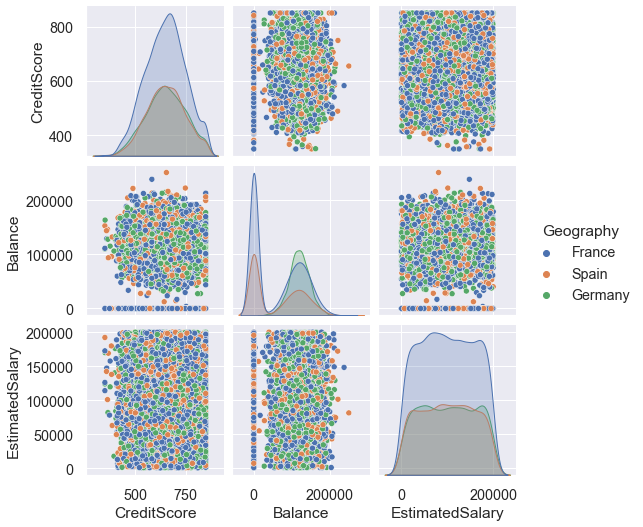

In [544]:
sns.pairplot(df[['CreditScore','Balance','EstimatedSalary','Geography']],
             hue="Geography")

It seems that pointsare distributd at random, with relationship to `Geography`. I'd like to investigate a different differentiating factor, `Tenure` seems like it could be grouped together, lets investigate it's range and and histogram distribution

<AxesSubplot:xlabel='Tenure', ylabel='Count'>

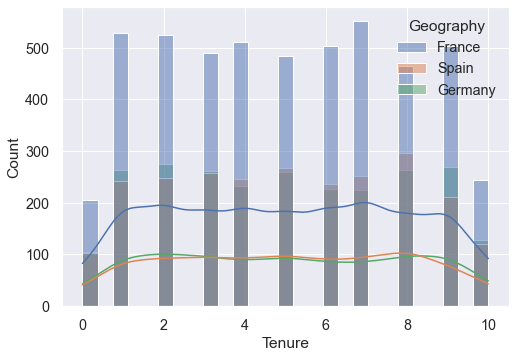

In [545]:
sns.histplot(data=df, x='Tenure', hue="Geography",
             kde='True')

Seems that years of`Tenure` are evenly distributed across `Geography` with exception of min and max years. This is a dead end.

# Classification Model

ANOVA helps to find different groups within a feature and eventually lead to more statistical procedures like GMM to decompose distributions into more features and improve model's performence. There are few numerical and categorical features for clasifier, and using `Exited` as our target I'll try few different models and fine tune the best. At the end I'll evaluate the model on unseen data and reflect at the findings

##### Train, test split

Before I do any insightful procedure it's best to split the data into train and test sets. First, lets consider the empact of , lets think again about the distribution and consider if `Gender` and `Geography` plays a role in a response variable `Exited`, and overall if the dataset is balanced

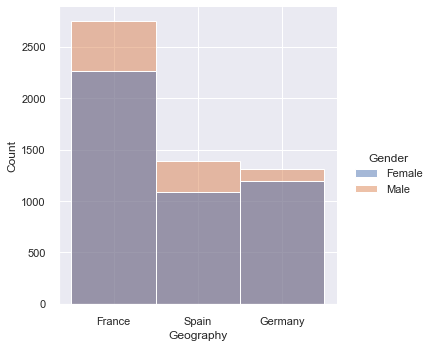

In [546]:
sns.set(style="darkgrid")
sns.displot(data=df, x='Geography', hue='Gender')

`France` has more almost double the clients of each `Spain` and `Germany`, while the latter two share roughly equal amount; `stratify=y` plays a significant role in the `train_test_split()` as it directly affects our training and testing distributions of all features

In [17]:
y, X = df['Exited'], df.drop('Exited',axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                    test_size=0.2,
                                    random_state=42, stratify=y)

When using `stratify=y` both X and y  must be present for splitting as the data becomes shuffled, affecting the indices of X and y

In [19]:
X_train = pd.concat([X_train, y_train],axis=1)
# I need this step for plotting, for setting `hue='Exited`, I made changes to code in revisions

In [550]:
X_train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2151,2152,15588614,Walton,753,France,Male,57,7,0.00,1,1,0,159475.08,1
8392,8393,15641158,Belcher,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1
5006,5007,15750014,Chikere,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0
4117,4118,15663964,Pagnotto,561,France,Male,37,5,0.00,2,1,0,83093.25,0
7182,7183,15573520,Rhodes,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0


Note that if `stratify=y` then `X and y` must both be present in `train_test_split()`, otherwise it will throw an error , and there's a good reason for that. If there'll be a stratification process then the order will be changed, as some of the values will be pulled out of order to accomodate an underlying distribution of the dataset, i.e. the same distribution of male to female, France to Germany and Spain, etc.

### EDA

I'd like to further investigate the dataset, especially focus an attention on custom made histogram, as they can really  make a difference, and even more profundly so when bins are in sensible width, i.e. credit score is a very important metric, and 50 points between the clients will describe a totally different user, but 20 points of a difference between might not be as significant as it might boil down to a missed payment

In [551]:
X_train.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000
mean,4990.432875,1.569088e+07,650.752500,38.946625,5.016625,76381.207499,1.529500,0.708750,0.514875,99730.811581,0.20375
std,2896.482331,7.193619e+04,96.596432,10.526876,2.896791,62302.053597,0.581741,0.454367,0.499810,57335.116540,0.40281
min,1.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.00000
25%,2461.750000,1.562869e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50691.817500,0.00000
50%,4987.500000,1.568995e+07,652.000000,37.000000,5.000000,97055.145000,1.000000,1.000000,1.000000,99446.940000,0.00000
75%,7509.500000,1.575327e+07,717.000000,44.000000,8.000000,127633.195000,2.000000,1.000000,1.000000,148527.730000,0.00000
max,10000.000000,1.581569e+07,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.00000


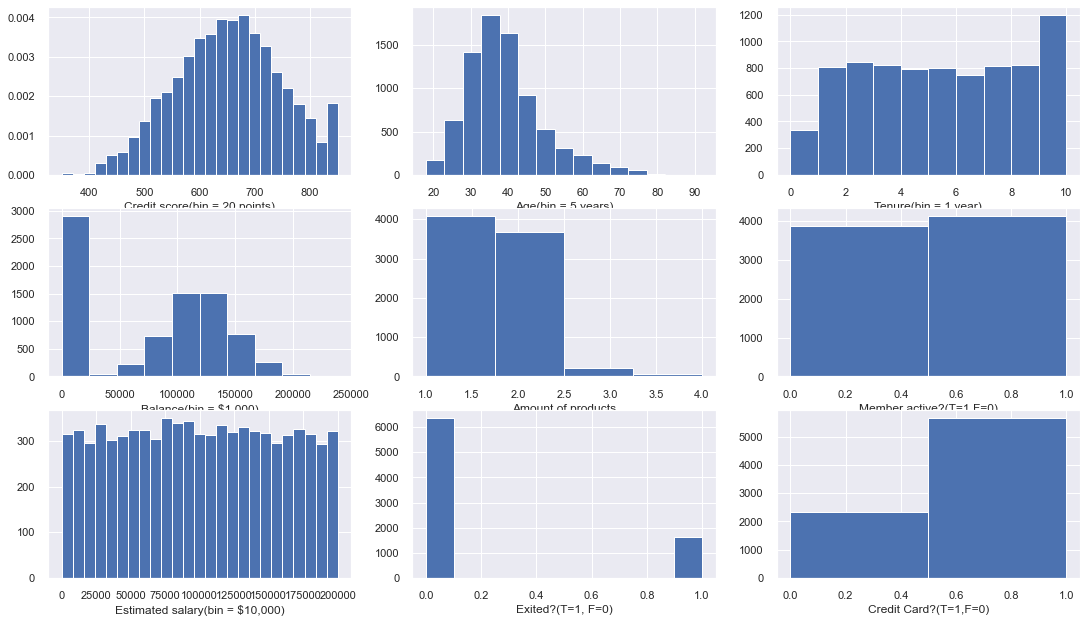

In [552]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(18.5, 10.5)
ax[0,0].hist(X_train.CreditScore, bins=25, density=True)
ax[0,0].set_xlabel('Credit score(bin = 20 points)')
ax[0,1].hist(x=X_train.Age, bins=15)
ax[0,1].set_xlabel('Age(bin = 5 years)')
ax[0,2].hist(x=X_train.Tenure, bins=10)
ax[0,2].set_xlabel('Tenure(bin = 1 year)')
ax[1,0].hist(x=X_train.Balance)
ax[1,0].set_xlabel('Balance(bin = $1,000)')
ax[1,1].hist(x=X_train.NumOfProducts, bins=4)
ax[1,1].set_xlabel('Amount of products')
ax[1,2].hist(x=X_train.IsActiveMember, bins=2)
ax[1,2].set_xlabel('Member active?(T=1,F=0)')
ax[2,0].hist(x=X_train.EstimatedSalary, bins=25)
ax[2,0].set_xlabel('Estimated salary(bin = $10,000)')
ax[2,1].hist(x=X_train.Exited)
ax[2,1].set_xlabel('Exited?(T=1, F=0)')
ax[2,2].hist(x=X_train.HasCrCard,bins=2)
ax[2,2].set_xlabel('Credit Card?(T=1,F=0)')
plt.show()

It was slightly laborious but the benefit of specyfing the size of the bins is immesurable when t comes to understandnig distributions and identyfing patterns. Based on the histograms, I'd like to note few observations

* `CreditScore` approx normal distribution, and more people with higher credit scores
* `Age` more younger people, especially between age 30-50 that left the bank, irrespectible of the income
* `Tenure` approx uniform with largest group of customer with 10 years tenure
* `Balance` most people have no balance, the rest have an avg of $125,000
* `NumOfProducts` customers mostly have 1 or 2 products
* `IsActiveMember` evenly split between active and inactive
* `EstimatedSalary` bank has customers from all groups of earners
* `Exited` most people are still customers of the bank, it's rare for a customer to leave
* `HasCrCard` majority has a credit card

It's important to notice that 3 out of 8 variables are binary, 2 are uniform, `CreditScore` is bounded by low and max which makes standarization(range 0-1) the most suitable, using GMM to decompose `Balance` might be of importance, and doing `OneHotEncode()` at some of the others seems as a good place to begin

There are features that could be treated by `OneHotEncoding` or `OrdinalEncoder` and each of them would yield a different outcome for the mode. I'd like to investigate what's the data is saying and look at relational plot while conditioning on `Exited`(making color destinction)

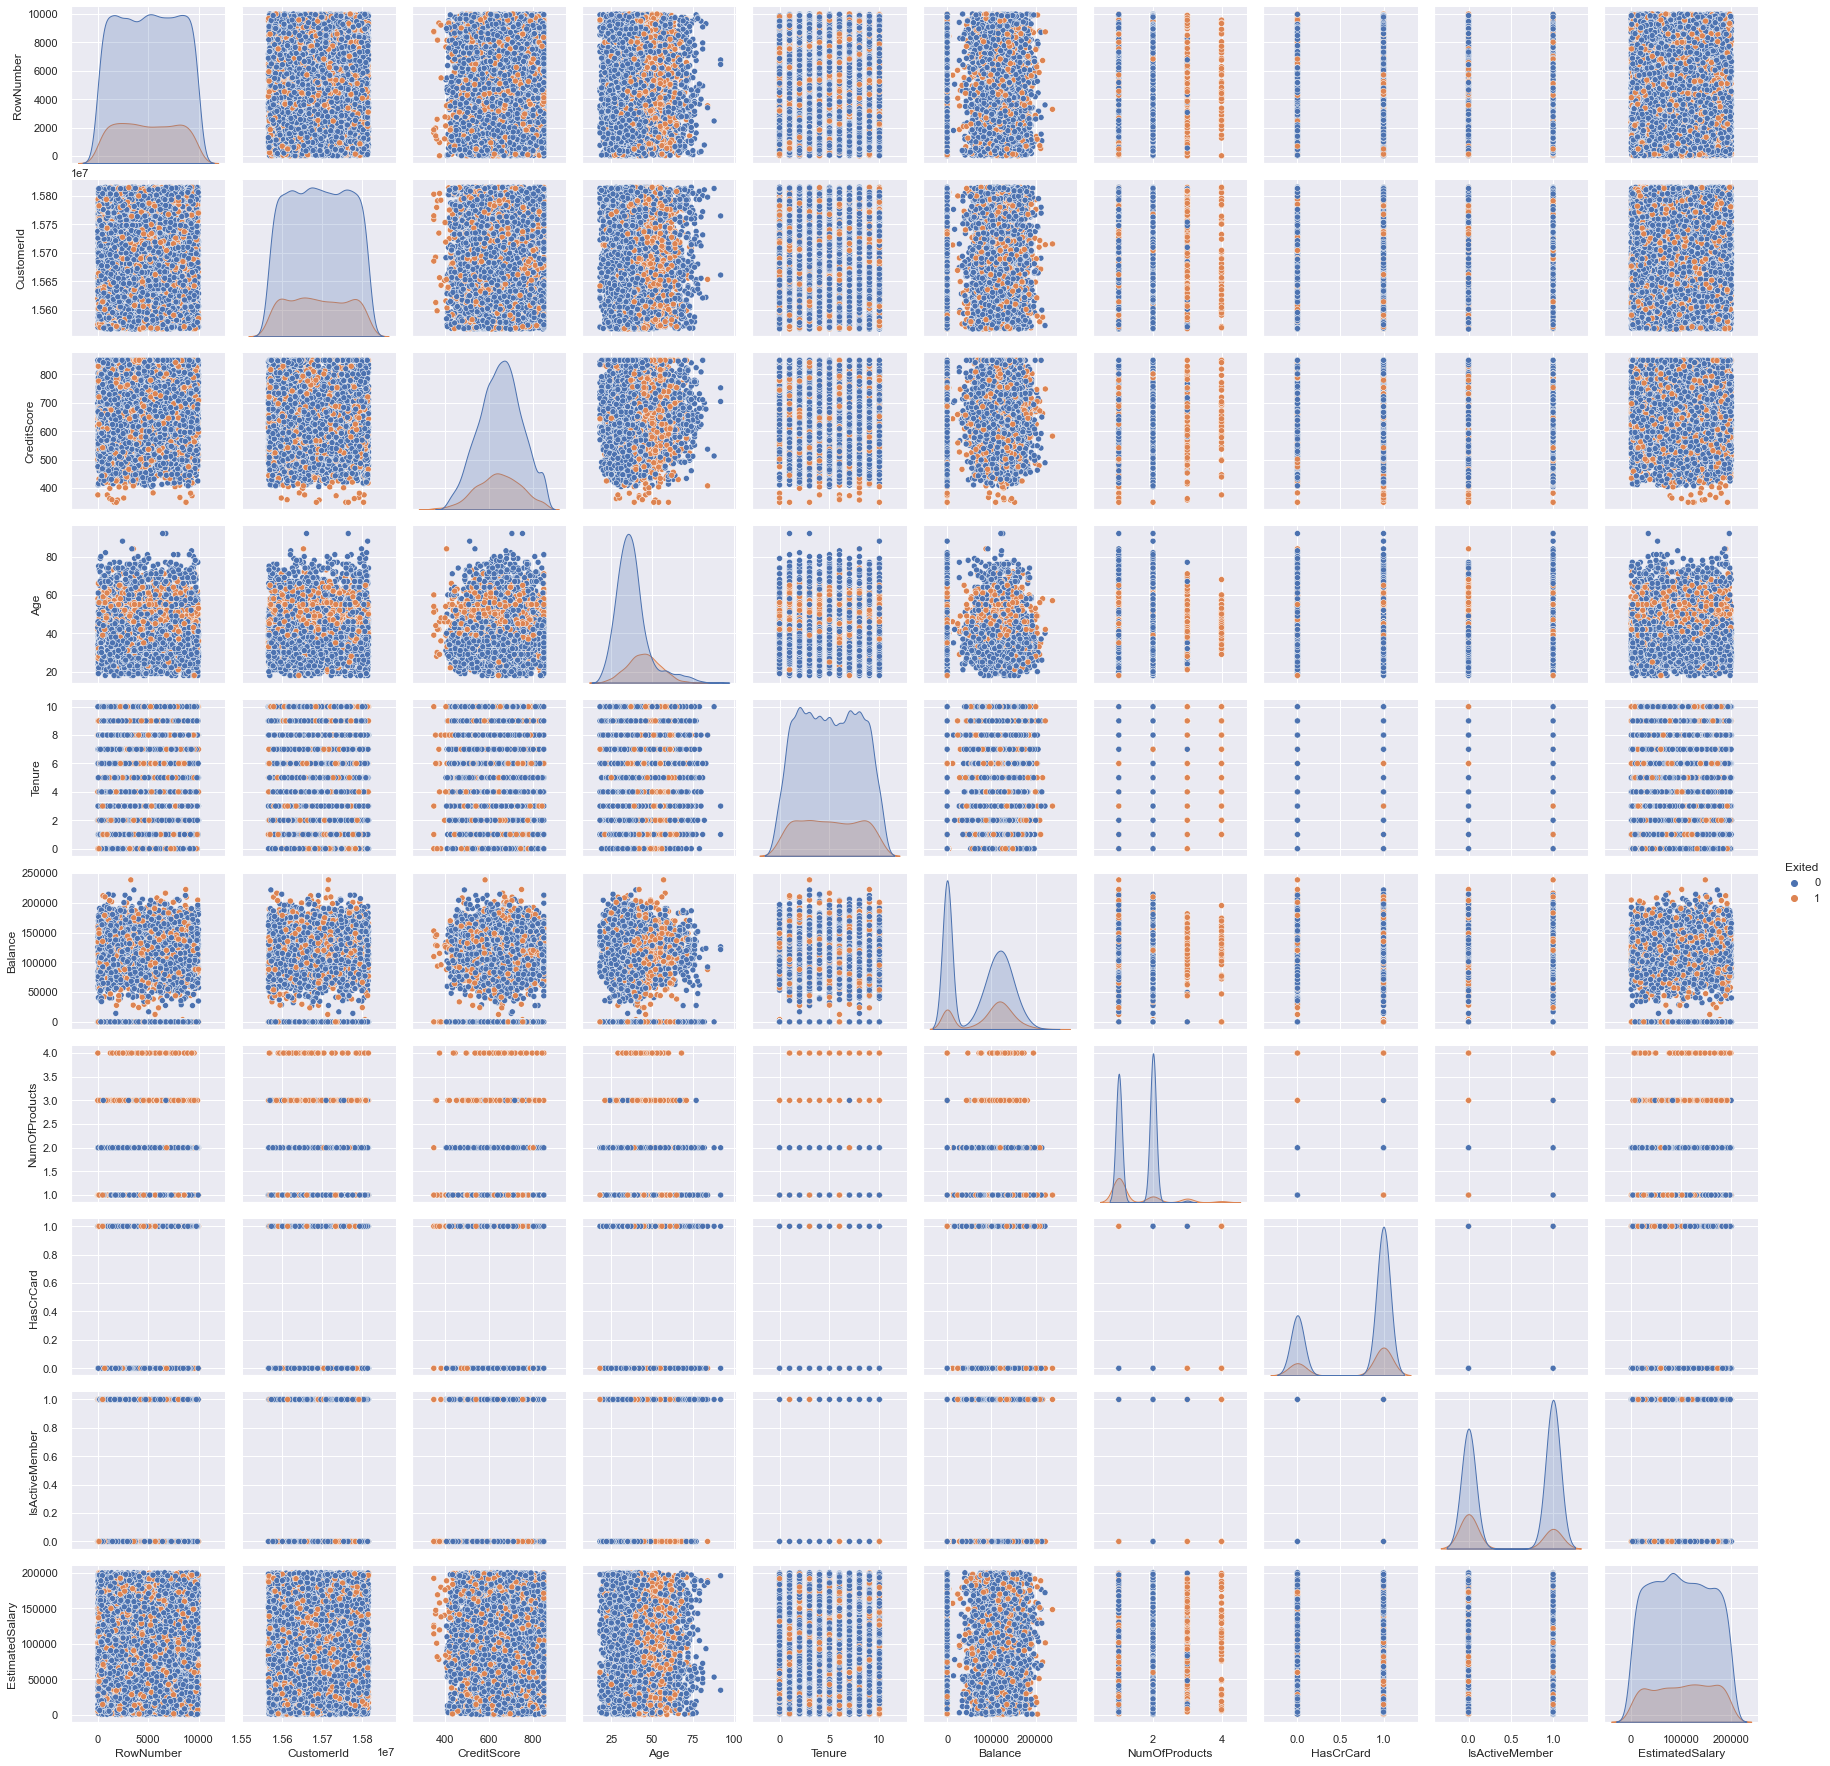

In [553]:
sns.pairplot(data=X_train,hue='Exited')

It seems that when it comes to `NumOfProducts` then it's necessary to use `OneHotEncode` since customers with 3 or 4 products are more likely to leave. A contributing factor might be that customer who acquired all the perks and products from the bank are looking for more encompasing institution elsewhere. It goes in the line with a saying to avoid being the smartest guy in the room, as that might not be conducive to growth

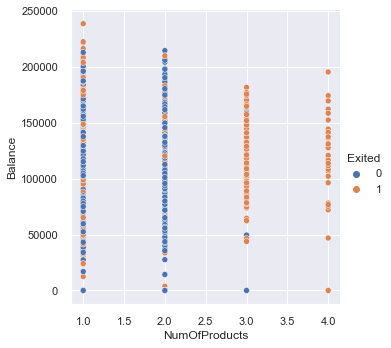

In [554]:
sns.relplot(data=X_train, x='NumOfProducts',y='Balance',hue='Exited')

Here's a larger plot showing the trend. It seems that customers with 3 and 4 products are nearly entirely made out of people who left, especially 4 products

### Pipeline

Geared with some of the insight I'm ready to create a `Pipeline` that will standarize and set a sequence of procedures by which `X_train` as well as `X_test` be handled. That procedure makes the process less prone to error, as I might forget to use a certain function, or doing it in a different order, i.e. `StandardScaler()` before `PowerTransform` will yield different results

In [25]:
one_hot_cols = ['Geography','Gender','HasCrCard','IsActiveMember','NumOfProducts']

In [26]:
ordinal_cols = ['Tenure'] # I decided that this column works better as a grade, like in school

In [27]:
num_cols = ['CreditScore','Age','Balance','EstimatedSalary']

In [21]:
X_train.drop(['Exited'], axis=1, inplace=True)

In [28]:
num_pipe = Pipeline([
    ('norm',StandardScaler()),
    ('poly',PolynomialFeatures(2)),
    ('transf', PowerTransformer(method='yeo-johnson', standardize=False))
    
])

I've used box-cox method for transformation since the data was slightly skewed with abnormal kurtosis. The  `method='yeo-johnson` accepts negative values, while `box-cox` doesn't, other than that works similarly in variance stabilization

In [29]:
full_pipe = ColumnTransformer([
    ('num',num_pipe, num_cols),
    ('one_hot_cat',OneHotEncoder(),one_hot_cols),
    ('ordinal_cat', OrdinalEncoder(),ordinal_cols),
    ('rm','drop',rm_cols)
])

In [30]:
type(X_train)

pandas.core.frame.DataFrame

In [31]:
X_train = full_pipe.fit_transform(X_train)

C:\Users\Henryk-Mariusz\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


### Fitting a model

The distribution of the response variable `Exited` is a very important aspect. When a dataset that doesn't have an approximately uniform distribution i.e. (50% True, 50% False) the model might not be able to capture the trend, and be less effective. In that case it's best to specify `class_weight='balanced'`, to inspect that visually is best to plot a histogram

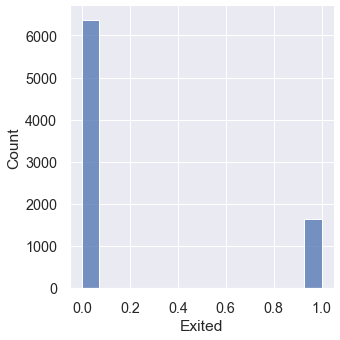

In [606]:
sns.displot(data=y_train)

In [563]:
y_train.sum() / len(y_train)

0.20375

The dataset is highly unbalanced with roughly 20% of customers who left the bank, we should definitely use parameter `class_weight='balanced'` to help the model with the estimation

#### Logistic regression

I'll use logistic regression as the first model. I really like that particular model because it's linear in parameters and has a lot of possible places to improve it, and at the same time it's very easy to implement and explain to non technical stakeholders

In [33]:
log_reg = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')

In [34]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
def eval_model(f,X,y):
    """
    few small diagnostic measures for checking the model:
    
    f: trained classifier 
    X: independent features
    y: response feature
    
    returns: confusion_matrix for cmap plotting
    
    upcoming : ROC AUC
    
    wlv m
    """
    y_pred = cross_val_predict(f,X,y, cv=3)
    conf_matrix = confusion_matrix(y,y_pred)
    df_cm = pd.DataFrame(conf_matrix, [['Exited=No','Exited=Y']], [['Exited=No','Exited=Yes']])
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.3) 
    sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16}) # font size
    plt.show()
    #https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format
    
    acc = cross_val_score(f,X,y)
    acc_mean = np.mean(acc)
    acc_std = np.std(acc)
    print(f"avg accuracy: {acc_mean}, sd: {acc_std}")
    f1 = f1_score(y,y_pred)
    print(f"f1 score: {f1}")
    recall = recall_score(y_train, y_pred)
    print(f"recall: {recall}")
    precision = precision_score(y_train, y_pred)
    print(f"precision: {precision}")
    
    
    return conf_matrix

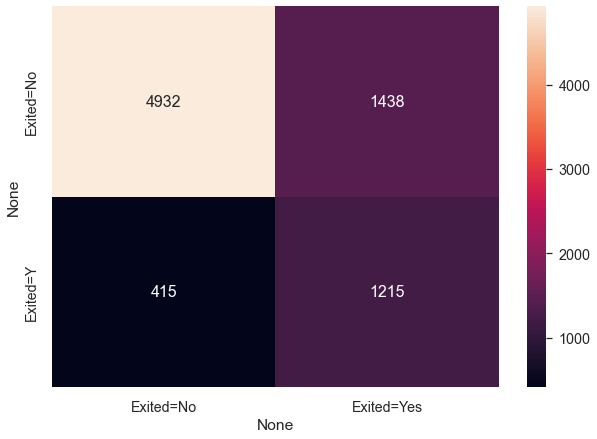

avg accuracy: 0.768125, sd: 0.005318011846545658
f1 score: 0.5673593275741302
recall: 0.745398773006135
precision: 0.4579721070486242


In [36]:
conf_matrix_log = eval_model(log_reg, X_train, y_train)

The model shows rather low accuracy with low variation in cross validation, low f1 score due to widely different recall and precision, recall which is higher and preffered for this problem, and low precision which is secondary to recall as I'll mention in the further comments. For clarity, the diagonal are TP for each class, rows are actuall class while columns predictions

In [37]:
y_scores = cross_val_predict(log_reg, X_train, y_train, cv=3,
                            method='decision_function')

In [38]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [39]:
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_scores)

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]          
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
#save_fig("roc_curve_plot")                                    
plt.show()

NameError: name 'fpr' is not defined

<Figure size 576x432 with 0 Axes>

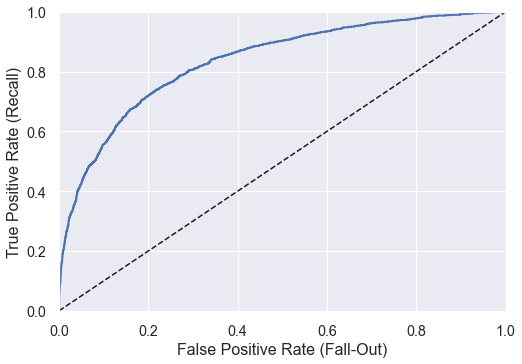

In [42]:
plot_roc_curve(fpr_log, tpr_log)

The roc_auc plot doesn't look impressing, its because in the attempt to maximize recall I increased `FPR` which are false positive cases, i.e. jumping at a dollar, only to realize it was attached to a string and pulled a kid from behind a tree, yes it happened to me, while my internal model categorized that dollar as ownerless one, and jumped into grabbing it but as it turned out it already had one

In [572]:
roc_auc_score(y_train, y_scores)

0.8355965944660072

This is area underneath the curve, ideal value should be 1, and the further it is the left top corner the better the model 

The results are not impressing. It seems that the algorithm is underfiting and unablet to capture people who exited the bank, and one of the solutions might be providing it with more powerful features. Looking at the plot I think that polynomial terms might be beneficial. But at some level, some people might leave bank without any particular reason, at random, and perhaps a large amount of customers do that

#### SGD Classifier

The second model I'd like to use is SGD classifier, which might give a better outcome out of the box

In [43]:
sgd_clf = SGDClassifier(random_state=42, class_weight='balanced')

In [44]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

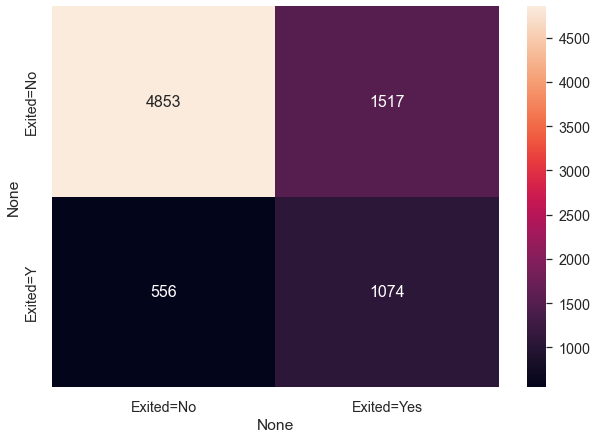

avg accuracy: 0.68425, sd: 0.10014629923267263
f1 score: 0.5088841506751953
recall: 0.6588957055214724
precision: 0.41451177151678886


In [45]:
conf_matrix_sgd = eval_model(sgd_clf, X_train, y_train)

The SGD classifier performs worse than log. regression comparing to `f1_score_log=`, `recall_log=`, and `precision_log=`

In [46]:
y_scores_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=3,
                            method='decision_function')

In [47]:
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train, y_scores_sgd)

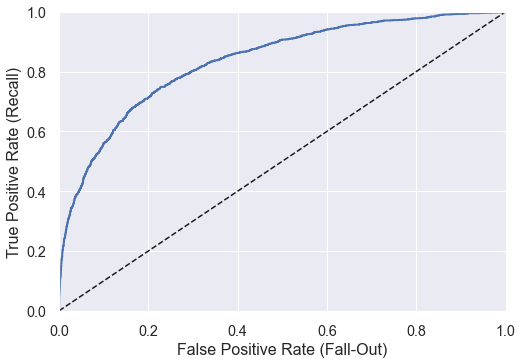

In [578]:
plot_roc_curve(fpr_sgd, tpr_sgd)

In [579]:
roc_auc_score(y_train, y_scores_sgd)

0.780099295971338

Looking at these two models, I can tell that Logistic Regression is overall a better way to go since we're trying to prioritize high recall, in cost of precision, ignoring to some extent accuracy

#### KNN classifier

In [143]:
kn_clf = KNeighborsClassifier(weights='distance', n_neighbors=5)

In [144]:
kn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

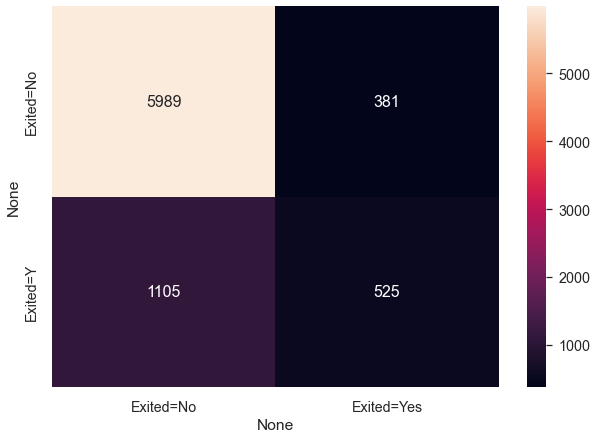

avg accuracy: 0.81425, sd: 0.006116064911362531
f1 score: 0.41403785488958994
recall: 0.3220858895705521
precision: 0.5794701986754967


array([[5989,  381],
       [1105,  525]], dtype=int64)

In [125]:
eval_model(kn_clf, X_train, y_train)

It doesn't impress me, but I have a good feeling about the algorithm based on what I've read online and looking at the data and the way it clusters the `KNeighborsClassifier` might be a good fit with a proper hyperparameter tunning

In [186]:
param_grid_kn = [
    {'n_neighbors': np.arange(1,11,1), 'weights': ['uniform','distance']}
    #{'n_neighbors': [1,2,3,4,5,6,7,8,9,10], 'weights': ['uniform','distance']}
]

In [187]:
grid_search_kn = GridSearchCV(kn_clf, param_grid_kn, cv=5,
                              scoring='recall')

In [188]:
grid_search_kn.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='distance'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [189]:
cvres = grid_search_kn.cv_results_

In [190]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print( mean_score, params)

0.3834355828220859 {'n_neighbors': 1, 'weights': 'uniform'}
0.3834355828220859 {'n_neighbors': 1, 'weights': 'distance'}
0.18466257668711655 {'n_neighbors': 2, 'weights': 'uniform'}
0.3834355828220859 {'n_neighbors': 2, 'weights': 'distance'}
0.34294478527607364 {'n_neighbors': 3, 'weights': 'uniform'}
0.34846625766871164 {'n_neighbors': 3, 'weights': 'distance'}
0.22085889570552145 {'n_neighbors': 4, 'weights': 'uniform'}
0.3411042944785276 {'n_neighbors': 4, 'weights': 'distance'}
0.3220858895705522 {'n_neighbors': 5, 'weights': 'uniform'}
0.3239263803680982 {'n_neighbors': 5, 'weights': 'distance'}
0.2251533742331288 {'n_neighbors': 6, 'weights': 'uniform'}
0.3159509202453988 {'n_neighbors': 6, 'weights': 'distance'}
0.30552147239263805 {'n_neighbors': 7, 'weights': 'uniform'}
0.3079754601226994 {'n_neighbors': 7, 'weights': 'distance'}
0.23803680981595093 {'n_neighbors': 8, 'weights': 'uniform'}
0.3159509202453988 {'n_neighbors': 8, 'weights': 'distance'}
0.3024539877300613 {'n_nei

In [191]:
grid_search_kn.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

It seems that the best hyperparameter for `KneighborsClassifer` is `n_neighbors=1` which makes me worry about overfitting. On top of that, even after the hyperparameter tunning the model is not as good as I expected

### Fine tuning the model

It seems that out-of-the-box model of logistic regression performs really well, especially when it comes to optimization of recall. I'll continue to fine tune the model with `GridSearchCV` which helps to specify `regularization` thorugh hyper parameter `C` and a type of `penalty`

In [50]:
param_grid = [{'C': np.linspace(0.0001,1,50),
               'penalty': ['l1','l2']
}]

In [51]:
grid_search = GridSearchCV(log_reg, param_grid, cv=5,
                          scoring='recall')
# I used recall, as this is the most significant factor

In [52]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': array([1.0000000...
       6.53095918e-01, 6.73502041e-01, 6.93908163e-01, 7.14314286e-01,
       7.34720408e-01, 7.55126531e-01, 7.75532653e-01, 7.95938776e-01,
       8.16344898e-01, 8.36751020e-01, 8.57157143e-01, 8.77563265e-01,
       8.97969388e-01, 9.18375510e-01, 9.38781633e-01, 9.59187755e-01,
       9.

In [53]:
grid_search.best_params_

{'C': 0.02050612244897959, 'penalty': 'l1'}

In [584]:
grid_search.best_estimator_

LogisticRegression(C=0.02050612244897959, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [585]:
log_reg

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

I took a look at two different logistic regression models to determine the differences myself, it changed the penalty to `l2` and `C=0.020506...`. Lets capture that model and re-train it on a data

In [54]:
log_reg_final = grid_search.best_estimator_

In [56]:
log_reg_final.fit(X_train,y_train)

LogisticRegression(C=0.02050612244897959, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluating the final model

In the `GridSearchCV` I used `scoring='recall'` because I'd like to get a higher recall for the price of precision

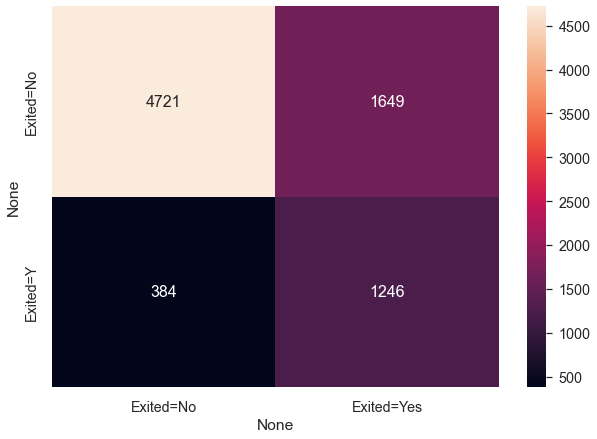

avg accuracy: 0.74875, sd: 0.006857933362172621
f1 score: 0.5507182320441989
recall: 0.7644171779141105
precision: 0.4303972366148532


In [57]:
conf_matrix_final = eval_model(log_reg_final, X_train, y_train)

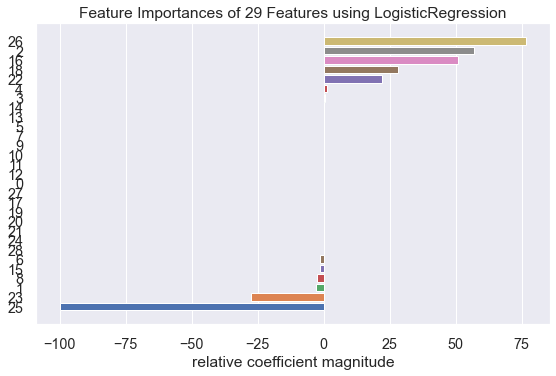

<AxesSubplot:title={'center':'Feature Importances of 29 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [59]:
viz = FeatureImportances(log_reg_final)
viz.fit(X_train, y_train)
viz.show()

The model has lots of features that don't add to the predictive power, it's measured at a linear factors the same way a linear regression measures coefficients. This way I see values and the larger in absolute sense, are the most predictive when it comes to estimatin if a customer `Exited`

In [60]:
all_features = list(viz.features_)

In [61]:
good_features = [26,2,16,18,22,3,25,23,8,15,1,28] #observed names from the chart

In [63]:
drop_features = [x for x in all_features if x not in good_features] #removes objects 

In [64]:
X_train = pd.DataFrame(X_train)

I captured the features by eye, I'd like to figure out a better way to do that without methods prone to mistakes. At the same time I'd like to preserve names of the dataframe together with names for polynomial features, so I could explain at the end what's the most important features are to make a determination

In [66]:
df1 = X_train.drop(labels=drop_features, axis=1,inplace=False)

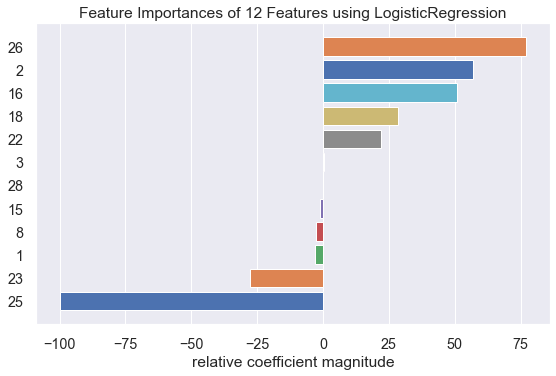

<AxesSubplot:title={'center':'Feature Importances of 12 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [67]:
log_reg_final.fit(df1,y_train)
viz = FeatureImportances(log_reg_final)
viz.fit(df1, y_train)
viz.show()

### Test set

Now's the time to evaluate the model and see how it performs

In [596]:
X_test1 = full_pipe.transform(X_test)

In [597]:
X_test_df = pd.DataFrame(X_test1)

In [598]:
X_test_df.drop(drop_features, axis=1,inplace=True)

In [599]:
y_test_pred = log_reg_final.predict(X_test_df)

In [600]:
conf_matr_final = confusion_matrix(y_test, y_test_pred)

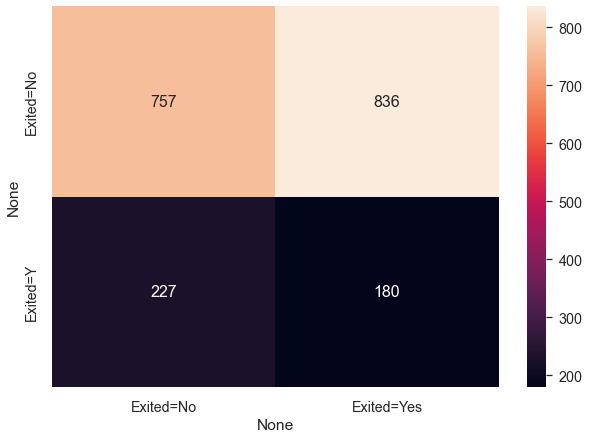

In [601]:
df_cm = pd.DataFrame(conf_matr_final, [['Exited=No','Exited=Y']], [['Exited=No','Exited=Yes']])
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3) 
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16}) # font size

plt.show()

#https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format

In [602]:
recall_score(y_test, y_test_pred)

0.44226044226044225

In [603]:
precision_score(y_test, y_test_pred)

0.17716535433070865

Although the model behaves similarly to train test, it leaves a lot for improvement. By choosing the model with higher recall I can make sure that I can catch as many people who're about to leave as possible. In the age of a robocalls, emails, and automated notification I can send right notifications to customers just in case, even when they don't have an intention, and nothing suggests that they might leave anytime soon. This way, at least looking at the test set, we can skip on generating a special mode of notification, to everbody and focus on the smaller group of customers. 